# 3D Computer Vision - Exercise 6

In this weeks exercise you will be teaching neural network to detect bunnies! There is plenty of code provided that should make it very possible for you to do this task.

To make things a bit easier we will use `pycocotools` which can be installed using `pip install pycocotools`. In addition we will be using PyTorch, which is a very popular machine learning framework for Python.

Code created by Joona Kareinen and Samuel Repka


## 1.0 Create the dataset

The training partition of the rabbit dataset is already augmented to create 30 versions of each source image:
- Random brigthness adjustment of between -25 and +25 percent

- Random exposure adjustment of between -25 and +25 percent

- Random cutout with 3 boxes

Does the code do further augmentation?

In [1]:
import torch
from torch.utils.data import DataLoader
from utils.dataset import RabbitDataset
from utils.loss import YOLOLoss
from utils.utils import plot_image_with_boxes, compute_iou, find_best_bbox, draw_bounding_box
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for consistent results. DO NOT CHANGE!
torch.manual_seed(42)

# Set dataset paths
data_dir = Path("./Cottontail-Rabbits")
train_ann_file = data_dir / "train" / "_annotations.coco.json"
valid_ann_file = data_dir / "valid" / "_annotations.coco.json"
test_ann_file = data_dir / "test" / "_annotations.coco.json"

train_dataset = RabbitDataset(train_ann_file, apply_transform=True)
valid_dataset = RabbitDataset(valid_ann_file)
test_dataset = RabbitDataset(test_ann_file)

print()
print(f"Train dataset contains: {len(train_dataset)} images")
print(f"Validation dataset contains: {len(valid_dataset)} images")
print(f"Test dataset contains: {len(test_dataset)} images")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Train dataset contains: 1890 images
Validation dataset contains: 19 images
Test dataset contains: 10 images


## 1.1 Visualize the output of dataset
The dataset gives as output a tuple that contains `(img, target)`:

- `img`: A torch tensor of shape `[channels, height, width]`, representing the image.

- `target`: A torch tensor of shape ...   

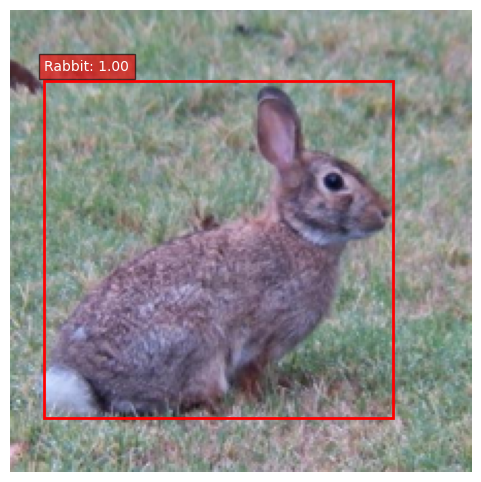

In [ ]:
# TODO: Answer what the dataset returns as targets. 

# Select an index
idx = 0
image, target = valid_dataset[idx]

# Visualize the image
plot_image_with_boxes(image, target)

## 1.2 Define dataloaders and the target device

Set batch_size and num_workers to values suitable for you PC.

- `batch_size` affects how many images is in each batch

- `num_workers` affects how many subprocesses is used for data loading

In [3]:
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, num_workers=4, shuffle=False)

# Automatically sets device to cuda if cuda is available. Otherwise uses cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.3 Define training and validation loops

In [9]:
# Training loop
def train_epoch(loader, model, criterion, optimizer):
    # Set model to training mode
    model.train()
    
    # Define epoch loss
    epoch_loss = 0
    losses = []
    for images, targets in tqdm(loader):
        
        # Move images to device
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())

    # Return average loss 
    return losses

# Validation loop
def validate(loader, model, criterion):
    # Set model to validation mode
    model.eval()
    
    # Define epoch loss
    val_loss = 0
    
    # During validation we can skip gradient computation
    with torch.no_grad():
        for images, targets in loader:
            
            # Move images to device
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            
            # Optional plotting
            # plot_image_with_boxes(images[0].cpu(), outputs[0].cpu())

    # Return average loss 
    return val_loss / len(loader)

## 1.4 Define the model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils.config as config

from torchvision.models import alexnet, resnet18, resnet50

class YOLOv1ResNet(nn.Module):
    def __init__(self, backbone_type="alexnet"):
        super().__init__()
        ##### Do not change. 
        # Load backbone
        if backbone_type == "alexnet":
            backbone = alexnet(weights="DEFAULT")
            out_channels = 256
        elif backbone_type == "resnet18":
            backbone = resnet18(weights="DEFAULT")
            out_channels = 512
        elif backbone_type == "resnet50":
            backbone = resnet50(weights="DEFAULT")
            out_channels = 2048
        else:
            raise ValueError('backbone_type should be alexnet, resnet18, or resnet50')

        # Freeze backbone weights
        backbone.requires_grad_(False)

        # Delete last two layers as they contain the classifier
        backbone = nn.Sequential(*list(backbone.children())[:-2])
        #####
        
        # Ensures that the output from any backbone is same size 
        # Resizes the output to (B, 1024, 6, 6)
        self.channels = 1024
        resize = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)), nn.Conv2d(out_channels, self.channels, kernel_size=1)
        )

        # put it together so you do not forget to resize anything
        self.backbone = nn.Sequential(backbone, resize)

        # Match output size
        self.detector = DetectionNet(self.channels)

    def forward(self, x):
        out = self.backbone(x)
        # TODO: implement the forward pass

        return ...

class DetectionNet(nn.Module):
    """Network taking in the features from pretrained backbone and outputting the predictions."""

    def __init__(self, in_channels):
        super().__init__()

        # TODO: implement the model architecture

    def forward(self, x):
        # TODO: implement the forward pass
        return ...

## 1.5 Train the model

In [ ]:
# Instantiate the model:
model = YOLOv1ResNet(backbone_type="alexnet")
model.to(device)

# define loss and optimizer
loss_fn = YOLOLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train
num_epochs = 3
losses = []
val_losses = []
for epoch in range(num_epochs):
    epoch_losses = train_epoch(train_loader, model, loss_fn, optimizer)
    val_loss = validate(valid_loader, model, loss_fn)

    train_loss = sum(epoch_losses) / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    losses.extend(epoch_losses)
    val_losses.append(val_loss)

### Plot losses

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss")
plt.grid()

plt.subplot(1,2,2)
plt.plot(val_losses)
plt.title("Validation Loss")
plt.grid()
plt.show()

## Test the model

In [ ]:
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(2, 5, figsize=(16, 6))
    
    # Flatten axes for easier indexing if multiple rows
    ax = ax.flatten()
    
    for idx, (image, target) in enumerate(test_dataset):
        # Get the tuple
        image_model = image.unsqueeze(0).to(device)
        pred = model(image_model).cpu().squeeze(0)
        pred_bbox, confidence = find_best_bbox(pred, image.shape[1])
        target_bbox, _ = find_best_bbox(target, image.shape[1])
        iou = compute_iou(pred_bbox, target_bbox)
       
        # Unnormalize 
        image = image*0.25 + 0.5
        ax[idx].imshow(image.permute(1, 2, 0).numpy())
        # Draw bounding box
        draw_bounding_box(ax[idx], pred_bbox, confidence)
        draw_bounding_box(ax[idx], target_bbox, confidence=None, color="blue")
        ax[idx].set_title(f"IoU: {iou:.3f}")
        ax[idx].axis("off")
    plt.show()